In [14]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, root_mean_squared_error

In [2]:
df = pd.read_csv("data/train.csv")
df.head()

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987


In [3]:
# drop 'id', 'breath_id', and 'pressure' from the predictors
X = df[['R', 'C', 'time_step', 'u_in', 'u_out']]
y = df['pressure']

## Split the data

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_val.shape)

Training set shape: (4828800, 5)
Test set shape: (1207200, 5)


In [5]:
pipeline = Pipeline([
    ('poly', PolynomialFeatures()),
    ('lr', LinearRegression())
])

param_grid = {
    'poly__degree': [1, 2, 3, 4]
}

# Use GridSearchCV to find the best polynomial degree with 5-fold cross validation on the training set
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_absolute_error', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_degree = grid_search.best_params_['poly__degree']
print("Best polynomial degree:", best_degree)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best polynomial degree: 4


## Evaluate the model performance

In [15]:
# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_val_pred = best_model.predict(X_val)

mae = mean_absolute_error(y_val, y_val_pred)
print("Mean Absolute Error (MAE):", mae)

mse  = mean_squared_error(y_val, y_val_pred)
print("Mean Squared Error (MSE):", mse)

rmse  = root_mean_squared_error(y_val, y_val_pred)
print("Root Mean Squared Error (RMSE) Score:", rmse)

r2 = r2_score(y_val, y_val_pred)
print("R2 Score:", r2)

Mean Absolute Error (MAE): 2.5837414937040393
Mean Squared Error (MSE): 22.26194928906052
Root Mean Squared Error (RMSE) Score: 4.718257018122319
R2 Score: 0.6615750402619482


## Prepare submission using the test dataset

In [7]:
df_test = pd.read_csv("data/test.csv")

# Prepare test features
X_test = df_test[['R', 'C', 'time_step', 'u_in', 'u_out']]

# Predict the pressure values for the test set
test_predictions = best_model.predict(X_test)

# Create a submission
submission_df = pd.DataFrame({
    "id": df_test["id"],
    "pressure": test_predictions
})

# Save the submission file as CSV
submission_df.to_csv("submission.csv", index=False)
print("Submission file 'submission.csv' created successfully.")

Submission file 'submission.csv' created successfully.


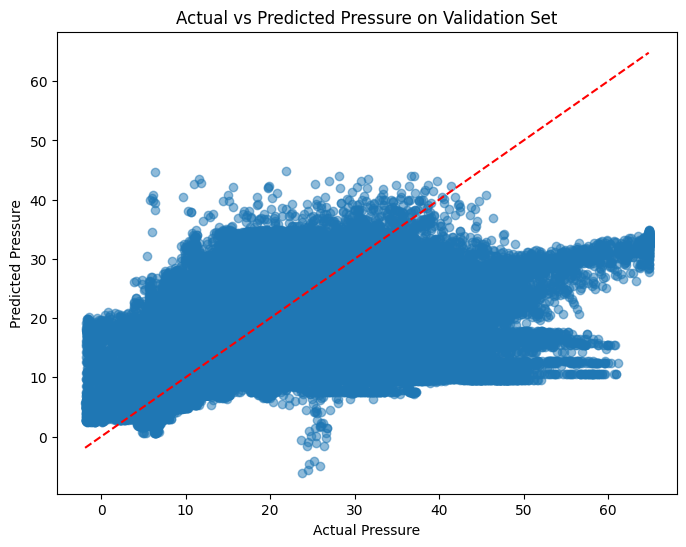

In [8]:
# Visualize Actual vs Predicted Pressure on the validation set
plt.figure(figsize=(8, 6))
plt.scatter(y_val, y_val_pred, alpha=0.5)
plt.xlabel("Actual Pressure")
plt.ylabel("Predicted Pressure")
plt.title("Actual vs Predicted Pressure on Validation Set")
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')  # Diagonal line for ideal predictions
plt.show()